<a href="https://colab.research.google.com/github/Guest-01/face-generator/blob/master/stylegan_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN2-ADA 시도해보기
NVlabs/stylegan2-ada를 이용해 얼굴이미지 생성해보기   
`https://github.com/NVlabs/stylegan2-ada`

In [ ]:
# 텐서플로우 1.x 사용
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# 코랩 로컬에 클론
!git clone https://github.com/NVlabs/stylegan2-ada.git

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 74 (delta 0), reused 1 (delta 0), pack-reused 71
Unpacking objects: 100% (74/74), done.


In [ ]:
# 사용할 사전 훈련된 모델의 피클 파일 경로를 구한다 https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/

## 간단하게 명령줄에서 이미지를 생성하는 법

In [ ]:
!python stylegan2-ada/generate.py --outdir=out --trunc=1 --seeds=1-3 \
    --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.
Generating image for seed 1 (0/3) ...
Generating image for seed 2 (1/3) ...
Generating image for seed 3 (2/3) ...


## 간단하게 코드로 생성하는 법

In [ ]:
# Import 할 수 있도록 PATH에 추가
import sys
sys.path.insert(0, "/content/stylegan2-ada")

In [ ]:
# generate.py 모듈에 generate_images 함수를 사용한다 (명령줄도 결국 이 함수를 호출한다)
from generate import generate_images

# 사용할 모델의 피클 경로
pkl_url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl"

# 사용법: generate_images(network_pkl, seeds, truncation_psi, outdir, class_idx, dlatents_npz)
generate_images(pkl_url, [1, 2, 3], 0.5, 'out', None, None)

## 함수 직접 만들기
모델을 직접 불러와서 이미지를 만들고 저장하지 않고 바로 보여주도록 만듬

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import dnnlib
import dnnlib.tflib as tflib

from itertools import zip_longest

def plot_images(images_arr, seeds):
  if len(images_arr) <= 10:
    row = 1
  else:
    row = len(images_arr) // 10

  fig, axes = plt.subplots(row, 10, figsize=(20, row*2))
  axes = axes.flatten()
  
  for img, ax, seed in zip_longest(images_arr, axes, seeds):
    if img:
      ax.set_title(seed)
      ax.imshow(img)
    ax.axis('off')
  # plt.tight_layout()
  plt.show()

def gen_imgs(seeds, pkl_url):
  tflib.init_tf()
  
  if pkl_url.startswith("http"):
    with dnnlib.util.open_url(pkl_url) as fp:
      _G, _D, Gs = pickle.load(fp)
  else:
    print(f"Loading from local pickle at {pkl_url}...")
    with open(pkl_url, "rb") as f:
      _G, _D, Gs = pickle.load(f)
  
  noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
  label = np.zeros([1] + Gs.input_shapes[1][1:])

  Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }

  imgs = []
  for seed in seeds:
    print(f"\rGenerating an img for seed: {seed}/{seeds[-1]}", end="")
    rnd = np.random.RandomState(seed)
    z = rnd.randn(1, 512)
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    img_array = Gs.run(z, label, **Gs_kwargs)
    img = PIL.Image.fromarray(img_array[0], 'RGB')
    imgs.append(img)
  plot_images(imgs, seeds)

* Official ffhq 512 model--------------------
Generating an img for seed: 20/20

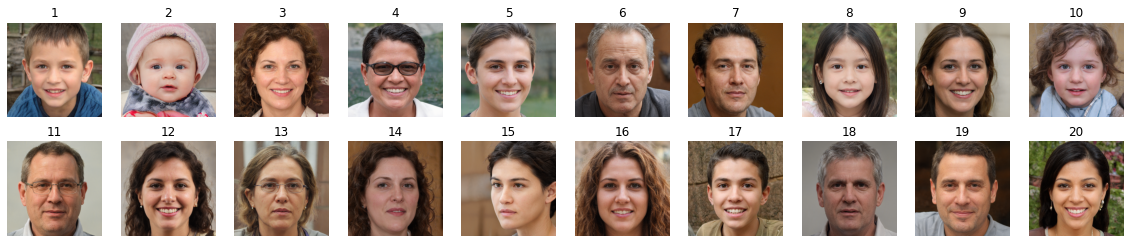

* Custom trained model-----------------------
Loading from local pickle at /content/drive/MyDrive/data/network-snapshot-000080.pkl...
Generating an img for seed: 20/20

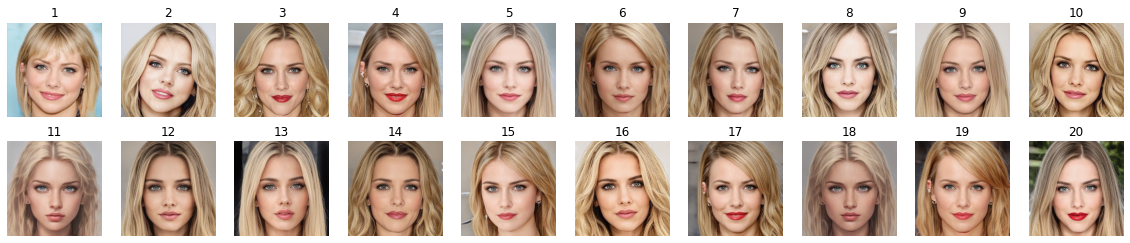

In [ ]:
# 사용할 모델 고르기
official = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl"
custom = "/content/drive/MyDrive/data/network-snapshot-000080.pkl"

# seed 리스트
seeds = range(1, 101) # 1 ~ 20

print("* Official ffhq 512 model--------------------")
gen_imgs(seeds, official)
print("* Custom trained model-----------------------")
gen_imgs(seeds, custom)

# Project 기능 사용해보기

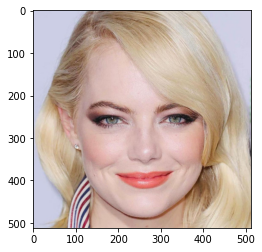

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread('/content/resized_crop_face36.jpg')
plt.imshow(image)
plt.show()

In [ ]:
!python stylegan2-ada/projector.py --outdir=out --target=resized_crop_face36.jpg \
    --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.
Projector: Computing W midpoint and stddev using 10000 samples...
Projector: std = 12.5404
Projector: Setting up noise inputs...
Projector: Building image output graph...
Projector: Building loss graph...
Projector: Building noise regularization graph...
Projector: Setting up optimizer...
Projector: Preparing target images...
Projector: Initializing optimization state...
  0% 0/1000 [00:00<?, ?it/s]2021-11-10 12:30:23.868265: W tensorflow/core/common_runtime/bfc_allocator.cc:305] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of t

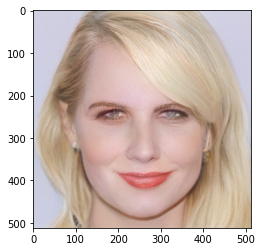

In [ ]:
image = img.imread('/content/out/proj.png')
plt.imshow(image)
plt.show()

# Style-Mixing 시도해보기
작성중...